## Self Taught Learning 

#### Import libraries

In [1]:
library(ggplot2) # for plots
library(h2o) # for building neural network models
h2o.init()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\arthp\AppData\Local\Temp\Rtmpg9W7jZ\file366450ce4e1b/h2o_arthp_started_from_r.out
    C:\Users\arthp\AppData\Local\Temp\Rtmpg9W7jZ\file36648591f7a/h2o_arthp_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 770 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    19 days  
    H2O cluster name:           H2O_started_from_R_arthp_cnt552 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.51 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Inte

#### Load st_labeled.csv, st_unlabeled.csv and st_test.csv data sets and required libraries (e.g., H2O)

In [65]:
# for training autoencoder and classifier
labeled.frame <- h2o.importFile(path = 'data/st_labeled.csv' ,sep=',') 
# for training autoencoder
unlabeled.frame <- h2o.importFile(path = 'data/st_unlabeled.csv' ,sep=',') 
# for testing
test.frame <- h2o.importFile(path = 'data/st_test.csv' ,sep=',') 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [66]:
# remove NA from labeled, unlabeled and test data
labeled.frame <- h2o.na_omit(labeled.frame)
unlabeled.frame <- h2o.na_omit(unlabeled.frame)
test.frame <- h2o.na_omit(test.frame)

In [67]:
# convert labels to factor for train data
labeled.frame[,1] <- as.factor(labeled.frame$label)

# scale labeled data and unlabeled data
labeled.frame[,1] <- scale(labeled.frame[,1])
labeled.frame[,-1] <- scale(labeled.frame[,-1])
unlabeled.frame[,-1] <- scale(unlabeled.frame[,-1])

In [68]:
# NA for unlabeled data
unlabeled.frame[,1] <- NA

In [69]:
# concatenate labeled and unlabeled data
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
# convert labels to factor for test data 
test.frame[,1] <- as.factor(test.frame$label)

In [70]:
# scale test data
test.frame[,1] <- scale(test.frame[,1])
test.frame[,-1] <- scale(test.frame[,-1])

#### Train an autoencoder with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, …, 400 (i.e. from 20 to 400 with a step size of 20).

For each model in Step II, we calculate and record the reconstruction error which is simply the average of Euclidian distances between the input and output of the autoencoder.

We then build the 3-layer NN and change the number of its neurons to: 20, 40, 60, 80, .., 400. For each model, we calculate and record the test error.

####  Finally we augmented self-taught networks using the models learnt above. 

For each model:

A. We add the output of the middle layer of an autoencoder as extra features to the original feature set.

B. Train a 3-layer NN using all features (original + extra) and varying the number of hidden neurons as well. Then calculate the test error.

For example, each model should be developed as follows:

Model 1: 20 hidden neurons + extra 20 features (from an autoencoder),

Model 2: 40 hidden neurons + extra 40 features (from an autoencoder),
...,

Model 20: 400 hidden neurons + extra 400 features (from an autoencoder).

In [71]:
# Auxiallary function to calculate error rate
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [72]:
# for training data, initialize reconstruction error matrix
# and classification errors matrix
reconstruction.train.error <- matrix(NA, nrow=20, ncol=1)
reconstruction3.train.error <- matrix(NA, nrow=20, ncol=1)
classification.labeled.error <- matrix(NA, nrow=20, ncol=1)

# for testing data, initialize reconstruction error matrix
# and classification errors matrix
reconstruction.test.error <- matrix(NA, nrow=20, ncol=1)
reconstruction3.test.error <- matrix(NA, nrow=20, ncol=1)
classification.test.error <- matrix(NA, nrow=20, ncol=1)

Build Neural network and calculate reconstruction and classification errors

In [73]:
options(warn=-1)

for (k in seq(20, 400, 20)){
    
    # train autoencoder
    # 1 layer NN
    NN.model <-  h2o.deeplearning(    
        x = 1:ncol(train.frame), # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(k), # 1 layer with k number of hidden units
        epochs = 100, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE,  # is it an autoencoder? Yes!
        l2 = 0.01, # use l2 regularization with lambda 0.01
        seed = 123
    )
    
    # calculate reconstruction training error
    reconstruction.train.error[k/20] <- mean(h2o.anomaly(NN.model, train.frame))
    
    # calculate reconstruction testing error
    reconstruction.test.error[k/20] <- mean(h2o.anomaly(NN.model, test.frame))
    
    # 3 layers Classification NN
    NN3.model <-  h2o.deeplearning(    
        x = 2:ncol(labeled.frame),# select all pixels
        y = 1, # index of labels in df
        training_frame = labeled.frame, # specify the frame (imported file)    
        hidden = c(k), # 1 layer with k number of hidden units
        epochs = 2000, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE,  # not an autoencoder
        l2 = 0.05, # use l2 regularization with lambda 0.01
        seed = 43
    )
    
    # get prediction for 3 layer classifier on train data
    labeled3.predict <- h2o.predict(NN3.model, labeled.frame)$predict
    # calculate reconstruction error on training data
    reconstruction3.train.error[k/20]  <- error.rate(labeled.frame$label, labeled3.predict)
    
    # get prediction for 3 layer classifier on test data
    test3.predict <- h2o.predict(NN3.model, test.frame)$predict
    # calculate reconstruction error on training data
    reconstruction3.test.error[k/20]  <- error.rate(test.frame$label, test3.predict)
    
    # get learned features from hidden layer of autoencoder
    learned.features <- h2o.deepfeatures(NN.model, labeled.frame[,-1], layer=1)
    
    # concatenate learned feature with training input
    labeled.frame.learned <- h2o.cbind(labeled.frame, learned.features)
    
    # get learned features from hidden layer of autoencoder
    test.learned.features <- h2o.deepfeatures(NN.model, test.frame[,-1], layer=1)
    
    # concatenate learned feature with training input
    test.frame.learned <- h2o.cbind(test.frame, test.learned.features)
    
    NN3.augment.model <-  h2o.deeplearning(
                            x = 2:ncol(labeled.frame.learned), # all training data pixels + extra features
                            y = 1, # index of target variable
                            training_frame = labeled.frame.learned, #  the frame
                            hidden = c(k), # 1 hidden layer with 100 units
                            epochs = 2000,
                            activation = 'Tanh', 
                            autoencoder = FALSE, # classifier, not an autoencoder
                            l2 = 0.05,
                            seed = 43
                        )
    
    # predict on training data
    labeled.predict <- h2o.predict(NN3.augment.model, labeled.frame.learned)$predict
    # error rate for training data
    classification.labeled.error[k/20]  <- error.rate(labeled.frame.learned$label, labeled.predict)
    
    # predict on testing data
    test.predict <- h2o.predict(NN3.augment.model, test.frame.learned)$predict
    # error rate for training data
    classification.test.error[k/20] <-  error.rate(test.frame.learned$label, test.predict)

    
    # remove used models that accumulate in memory
    rm(NN.model, NN3.model, NN3.augment.model)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

#### Create data frames for classification and reconstruction errors

In [74]:
# sequence of hidden units
hidden_seq <- matrix(seq(20, 400, 20),ncol = 1)

In [75]:
# for reconstruction error on single layer autoencoder
reconstruction.train.error  <- cbind(hidden_seq,reconstruction.train.error)
colnames(reconstruction.train.error)  <- c("K","Reconstruction_train_err")

reconstruction.test.error  <- cbind(hidden_seq,reconstruction.test.error)
colnames(reconstruction.test.error)  <- c("K","Reconstruction_test_err")

In [82]:
# acummulating reconstruction error
error_trace_reconstruction <- merge(x <- reconstruction.train.error,
                           y <- reconstruction.test.error,
                           by <- "K", all = TRUE)

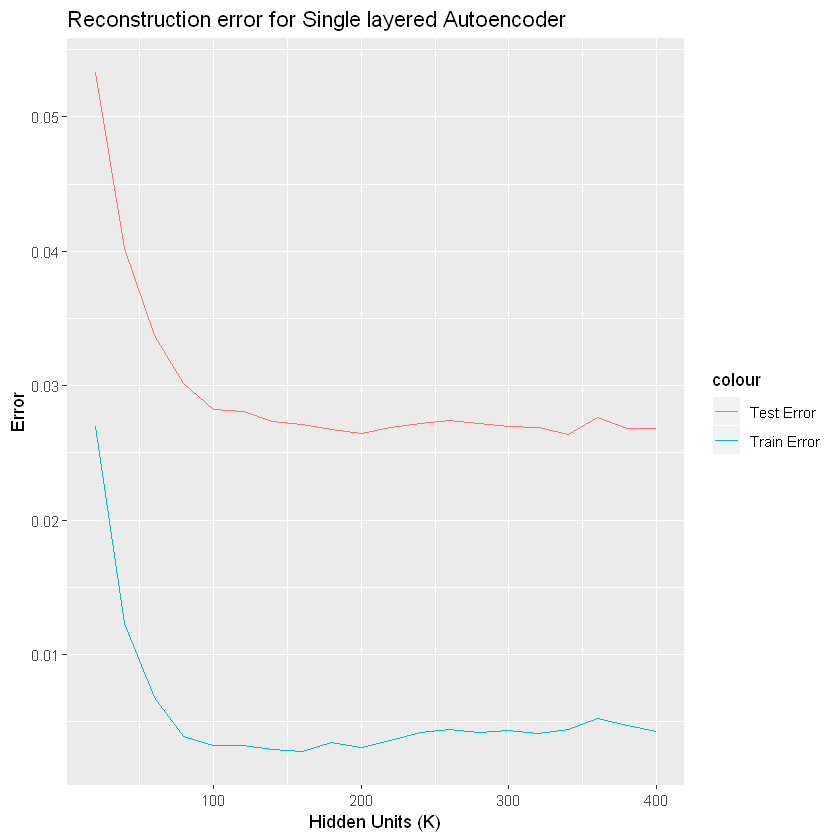

In [62]:
# plot reconstruction errors for 
ggplot(error_trace_reconstruction, aes(K)) + 
    geom_line(aes(y = Reconstruction_train_err, colour = "Train Error")) + 
    geom_line(aes(y = Reconstruction_test_err, colour = "Test Error")) +
    ggtitle('Reconstruction error for Single layered Autoencoder')+
    labs(x="Hidden Units (K)", y="Error")

From the above graph, we can see that with the increase in hidden units, the reconstruction error on training data increases. It decreases till there are 200 hidden units in the single layered auto-encoder. Once it reaches 200, the training error decreases which indicates that the model is overfitting on training dataset. This happens because the model complexity increases with the increase in number of hidden units. 

On test dataset, error decreases till 200 hidden units. After 200 units, the error remains constant on test dataset. This is because of the increase in model complexity. The significant decrease in the error on both the dataset indicates that the model is benefiting a lot due to increase in neurons till 100 and then the result of increase in neuron become negligible or worse.

Also, one more thing to note, lot of experiments were performed for different number of epochs and different value of lambda to get the desired results for both the plots. Increasing the value of regularization term smoothened the graph and eased out wiggly behaviour.


In [77]:
# errors on three layers NN classifier
reconstruction3.train.error  <- cbind(hidden_seq,reconstruction3.train.error)
colnames(reconstruction3.train.error)  <- c("K","Reconstruction3_train_err")

reconstruction3.test.error  <- cbind(hidden_seq,reconstruction3.test.error)
colnames(reconstruction3.test.error)  <- c("K","Reconstruction3_test_err")

In [79]:
# classfication error on self-taught learner 
classification.labeled.error  <- cbind(hidden_seq, classification.labeled.error)
colnames(classification.labeled.error)  <- c("K","Class_train_err")

classification.test.error  <- cbind(hidden_seq, classification.test.error)
colnames(classification.test.error)  <- c("K","Class_test_err")

In [81]:
# collecting classifiction error
error_trace <- merge(x <- reconstruction3.test.error, 
                     y <- classification.test.error, 
                     by <- "K", all = TRUE)

Plot the error rates for the 3-layer neural networks and the augmented self-taught networks , while the x-axis is the number of hidden neurons and y-axis is the classification error.

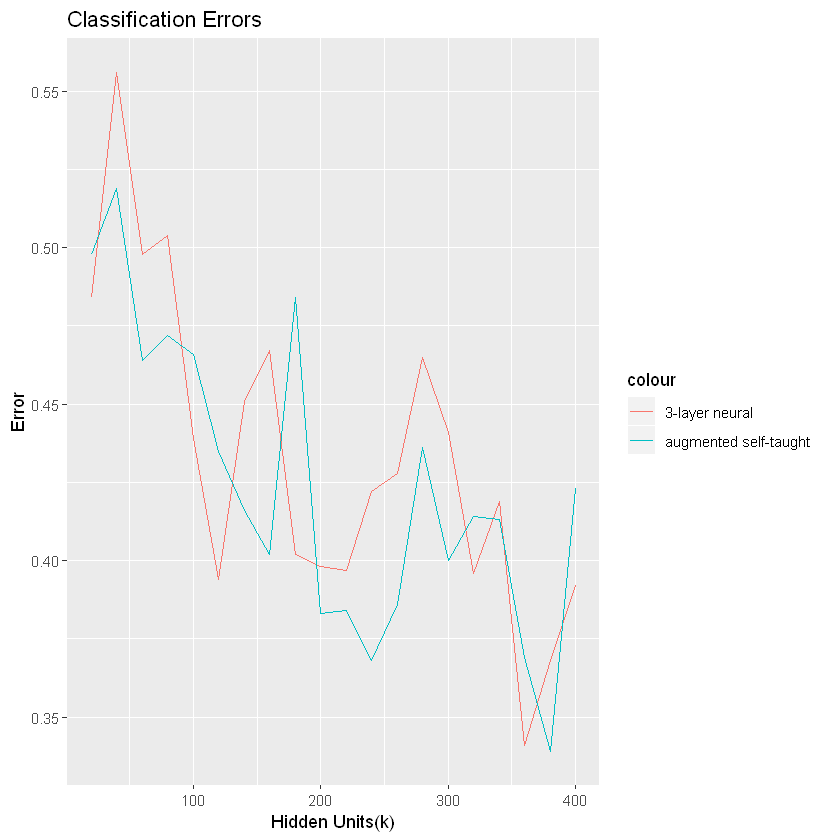

In [87]:
# plot classification error
ggplot(error_trace, aes(K)) + 
    geom_line(aes(y = Reconstruction3_test_err, colour = "3-layer neural")) + 
    geom_line(aes(y = Class_test_err, colour = "augmented self-taught")) +
    ggtitle('Classification Errors')+
    labs(x="Hidden Units(k)", y="Error")

#### Why/how these lines are different?

The classification error on simple 3 layered neural network and network formed by self-taught learning is shown above. We can observe that both the error trends are similar in one way which is the downward trend. So, we can say that with the increase in number of hidden units in the network, classification error is reducing. After 300 units, we see less reduction in error, which indicates the model might have reached local minima.

If we do performance comparison, self-taught learning provides a little better result than 3 layer neural network for most values of K (hidden units). This is because for self-taught learning, we have included learned features from autoencoder as input and neural-network being powerful feature selector, it is easily able to learn from these features along with actual inputs. So as the self-taught classifier has more USEFUL features to learn from, it is better able to classify the data exploiting inherent structure of input from the learned features.
